# Split spectrograms into channels

In [1]:
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

base_dir = pathlib.Path("../../kaggle_data/hms")
# base_dir = pathlib.Path("../../data/hms")
# base_dir = pathlib.Path("/kaggle/input/hms-harmful-brain-activity-classification")

2024-02-05 14:22:07.367651: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 14:22:07.464732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
df_traincsv = pd.read_csv(f'{base_dir}/train.csv')
idxs_wo_nan = np.load("../data/02_eegs_idxs_up_to_5_nan.npy")

# Removing observations where eeg has more than 5 NaN rows.
df = df_traincsv.iloc[idxs_wo_nan]
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [3]:
#
# Old version
#

# path_to_data = "/kaggle/input/hms-single-numpy/00_single_spectrograms_originals_numpy.npy"
# path_to_items = "/kaggle/input/hms-single-numpy/00_single_spectrograms_originals_numpy_items.npy"

# path_to_data = "../data/00_spectrograms_reduced.npy"
# path_to_items = "../data/00_sub_spectrograms_idxs_reduced.npy"

# data = np.load(path_to_data)
# items = np.load(path_to_items)
# n_total_samples = items.shape[0]

# ptrain = 0.8

# idx_train = np.array([], dtype=int)
# idx_val = np.array([], dtype=int)
# for i in np.arange(6):
#     idx = np.where(items[:,3] == i)[0]
#     idx = np.random.permutation(idx)
#     cut = int(ptrain*idx.shape[0])
#     idx_train = np.append(idx_train, idx[0:cut])
#     idx_val = np.append(idx_val, idx[cut:])

# items_train = items[idx_train]
# items_val = items[idx_val]
# print("Train samples:", len(items_train))
# print("Validation samples:", len(items_val))


In [6]:
#
# Train/Val split (v1)
#

ptrain = 0.8

# Set the seed for reproducibility.
rng = np.random.default_rng(113)
# rng = np.random.default_rng(45163)
# rng = np.random.default_rng(3233)

ids = rng.permutation(np.unique(df['patient_id']))
cut = int(ptrain * len(ids))
idxs_train = df.loc[df['patient_id'].isin(ids[0:cut])].index
idxs_val = df.loc[df['patient_id'].isin(ids[cut:])].index

print("Train samples:", len(idxs_train))
print("Validation samples:", len(idxs_val))

#
# -----------------
#

Train samples: 84191
Validation samples: 22167


In [13]:
#
# Data generator using numpy and no pandas.
#
# Original spectrograms.
# 50 seconds slice
# 4 channels
#

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, items, data, batch_size=32, n_classes=6, shuffle=True):
        ''' Initialization
        items: [eeg_id, eeg_sub_id, idx of offset, target]
        '''
        self.n_channels = 4
        self.n_freqs = 40
        self.dim = (25, self.n_freqs)

        self.data = data
        self.items = items
        self.batch_size = batch_size
        self.len = items.shape[0]
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.len / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.len)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        true_size = len(indexes)
        X = np.empty((true_size, *self.dim, self.n_channels))
        y = np.empty((true_size), dtype=int)

        # Generate data
        for i, idx in enumerate(indexes):
            item = self.items[idx]
            # print(item)  # Uncomment for testing.
            # Sample is 50 second long, that's 25 rows.
            initial = item[2] + 137
            final = initial + 25
            for c in np.arange(self.n_channels):
                cinitial = c * 100
                cfinal = cinitial + self.n_freqs
                X[i,:,:,c] = self.data[initial:final, cinitial:cfinal]
            # Store class
            y[i] = item[3]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [14]:

def make_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)

    #max1 = keras.layers.MaxPooling1D(pool_size=2)(input_layer)
    
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same")(input_layer)
    #conv1 = keras.layers.BatchNormalization()(conv1)
    # conv1 = keras.layers.MaxPooling2D(pool_size=8)(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=7, padding="same")(conv1)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    # conv2 = keras.layers.MaxPooling2D(pool_size=8)(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv2D(filters=256, kernel_size=7, padding="same")(conv2)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.MaxPooling2D(pool_size=2)(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    conv4 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same")(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.MaxPooling2D(pool_size=4)(conv4)
    conv4 = keras.layers.ReLU()(conv4)

    fltn  = keras.layers.Flatten()(conv4) 
    
    relu1 = keras.layers.Dense(256)(fltn)
    relu1 = keras.layers.ReLU()(relu1)

    relu2 = keras.layers.Dense(64)(relu1)
    relu2 = keras.layers.ReLU(64)(relu2)

#     lin = keras.layers.Dense(2)(relu2)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(relu2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [15]:
# Parameters
params = {
    'batch_size': 32,
    'n_classes': 6,
    'shuffle': True
    }

training_generator = DataGenerator(items_train, data, **params)
validation_generator = DataGenerator(items_val, data, **params)



In [16]:
# Testing this class.

X, y = training_generator.__getitem__(1)

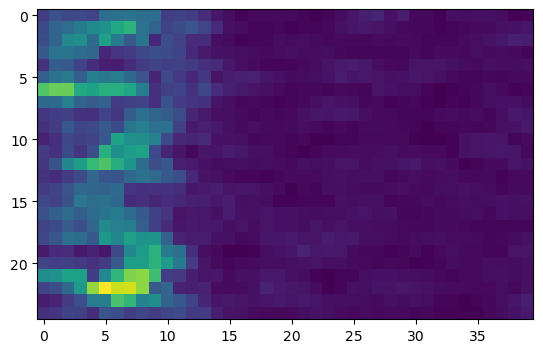

In [17]:
plt.imshow(X[1,:,:,3])

In [18]:
model = make_model(input_shape=(25,40,4), num_classes=6)
model.compile(optimizer='sgd',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.CategoricalCrossentropy()])

model.fit(training_generator, epochs=1, validation_data=validation_generator)


10/10 [==============================] - 5s 449ms/step - loss: 2.4234 - categorical_crossentropy: 2.4234 - val_loss: 3.0830 - val_categorical_crossentropy: 3.0830


In [19]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

#
# Test Data generator: for predicting.
#

class test_DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, ids, path_to_test_data, batch_size=32, n_classes=6):
        'Initialization'
        self.n_channels = 4
        self.dim = (25,40)
        self.n_freqs = 40

        self.path = path_to_test_data
        # self.files = os.listdir(path_to_test_data)
        self.ids = ids
        self.indexes = np.arange(len(self.ids))
        # self.columns = self.data.columns[2:]
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        # items_temp = self.items.iloc[indexes]

        # Generate data
        X = self.__data_generation(indexes)

        return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # self.indexes = np.arange(self.len)
        # if self.shuffle == True:
        #     np.random.shuffle(self.indexes)
        pass

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(indexes), *self.dim, self.n_channels))

        # Generate data
        for i, idx in enumerate(indexes):
            # item = self.items.iloc[idx]
            test_spectrogram = pd.read_parquet(f'{self.path}{self.ids[idx]}.parquet')
            test_spectrogram.replace(np.nan, 0, inplace=True)

            initial = 137
            final = initial + 25
            for c in np.arange(self.n_channels):
                cinitial = c * 100 + 1
                cfinal = cinitial + self.n_freqs
                # X[i,:,:,c] = self.data[initial:final, cinitial:cfinal]
                X[i,:,:,c] = test_spectrogram.iloc[initial:final,cinitial:cfinal].to_numpy(copy=True)

        return X


# Parameters
params = {
    'batch_size': 32,
    'n_classes': 6,
    }


# base_dir = pathlib.Path("/kaggle/input/hms-harmful-brain-activity-classification")

path_to_test_data = f'{base_dir}/test_spectrograms/'
test = pd.read_csv(f'{base_dir}/test.csv')
ids = test['spectrogram_id'].values

test_generator = test_DataGenerator(ids, path_to_test_data, **params)

y_pred = model.predict(test_generator)

sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = np.round(y_pred,6)
sub.to_csv('submission.csv',index=False)


1/1 [==============================] - 0s 170ms/step


In [20]:
sub

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.064463,0.067912,0.027104,0.753359,0.058459,0.028703
